Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


Load Data

In [2]:
df = pd.read_csv("/workspaces/group-project-team-omega/code/cleanedData/Final_Model_data.csv")

df = df.dropna(subset=["first_pit_lap"])


Feature + Target

In [3]:
final_features = [
    "year", "round", "circuitId",
    "driverId", "constructorId",
    "grid", "laps", "pit_stop_count",
    "track_length_km", "race_distance_km",
    "tyre_deg_level", "pit_lane_loss"
]



X = df[final_features]
y = df["first_pit_lap"]
# print(df.columns.tolist())



Categorical vs Numeric Split

In [4]:
cat_cols = ["circuitId", "driverId", "constructorId"]
num_cols = [col for col in final_features if col not in cat_cols]

Preprocessor

In [5]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)


Build Random Forest Pipeline

In [6]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

# # base pipeline (same as before)
# rf_base = Pipeline(steps=[
#     ("preprocess", preprocess),
#     ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
# ])

# # parameter grid for tuning
# param_grid = {
#     "model__n_estimators": [300, 500],
#     "model__max_depth": [10, 15, None],
#     "model__min_samples_leaf": [1, 2, 4],
#     "model__max_features": ["sqrt", "log2"]
# }

# # grid search
# grid_search = GridSearchCV(
#     rf_base,
#     param_grid,
#     cv=3,
#     scoring="neg_mean_absolute_error",
#     n_jobs=-1,
#     verbose=2
# )

# grid_search.fit(X_train, y_train)

# # best tuned model
# best_rf = grid_search.best_estimator_
# print("Best Params:", grid_search.best_params_)



Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Train

In [8]:
rf_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Predict

In [9]:
train_pred = rf_model.predict(X_train)
test_pred = rf_model.predict(X_test)


In [10]:
#Metrics
train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)

train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2:", train_r2)
print("Test R2:", test_r2)


Train MAE: 1.0072498286449907
Test MAE: 2.781642983371599
Train RMSE: 1.772865022279545
Test RMSE: 4.9094504303624795
Train R2: 0.943022919246365
Test R2: 0.5910970211277607


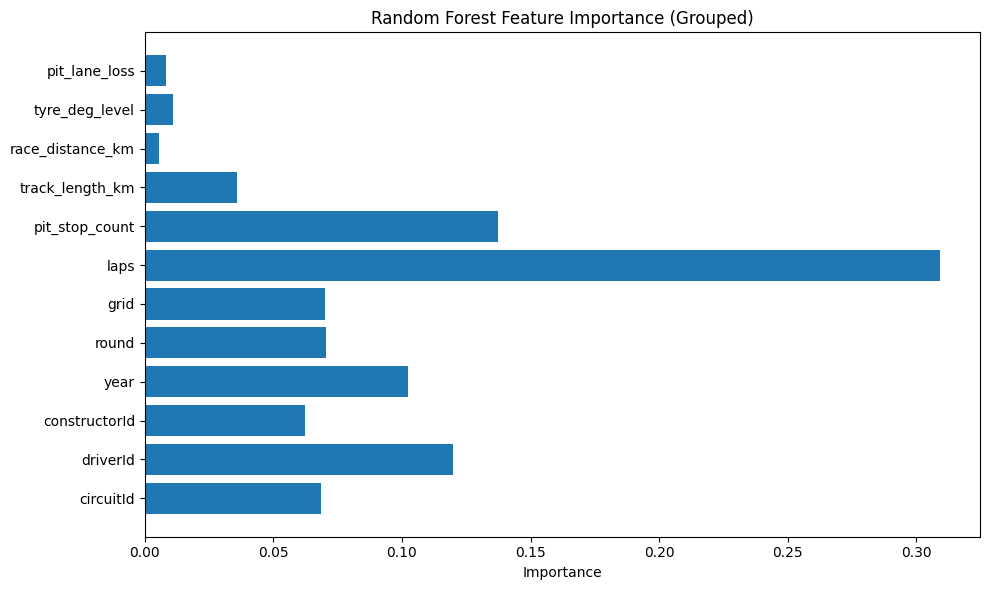

In [11]:
#VISUAL 1 — Feature Importance
import numpy as np
import pandas as pd

# extract trained RF model from pipeline
rf = rf_model.named_steps["model"]

# get encoded feature names
ohe = rf_model.named_steps["preprocess"].named_transformers_["cat"]
ohe_cols = ohe.get_feature_names_out(cat_cols)

# combined feature list (encoded cat + numeric cols)
all_feature_names = list(ohe_cols) + num_cols

# raw importances
raw_importances = rf.feature_importances_

# create dataframe
fi_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": raw_importances
})

# ---- GROUP BACK TO ORIGINAL FEATURES ----
grouped_importance = {
    "circuitId": fi_df[fi_df.feature.str.contains("circuitId")]["importance"].sum(),
    "driverId": fi_df[fi_df.feature.str.contains("driverId")]["importance"].sum(),
    "constructorId": fi_df[fi_df.feature.str.contains("constructorId")]["importance"].sum(),
}

# add numeric ones (direct)
for col in num_cols:
    grouped_importance[col] = fi_df[fi_df.feature == col]["importance"].sum()

# convert to dataframe for plotting
gi_df = pd.DataFrame(list(grouped_importance.items()), columns=["feature", "importance"])

# ---- PLOT CLEAN VERSION ----
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(gi_df["feature"], gi_df["importance"])
plt.title("Random Forest Feature Importance (Grouped)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


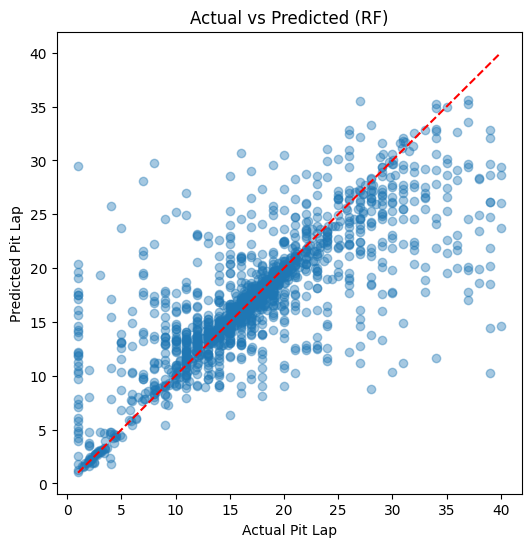

In [12]:
#VISUAL 2 — Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, test_pred, alpha=0.4)
plt.xlabel("Actual Pit Lap")
plt.ylabel("Predicted Pit Lap")
plt.title("Actual vs Predicted (RF)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.show()


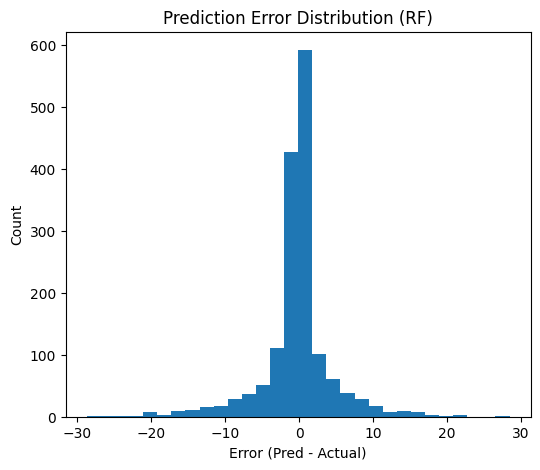

In [13]:
#VISUAL 3 — Error Distribution
errors = test_pred - y_test

plt.figure(figsize=(6,5))
plt.hist(errors, bins=30)
plt.title("Prediction Error Distribution (RF)")
plt.xlabel("Error (Pred - Actual)")
plt.ylabel("Count")
plt.show()


In [35]:
from sklearn.ensemble import ExtraTreesRegressor


ET model

In [36]:
import joblib

# save RF pipeline (preprocess + model)
joblib.dump(rf_model, "PlanA_RF_Model.pkl")
print("Saved RF model as PlanA_RF_Model.pkl")


In [37]:
et_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [39]:
#Predict
train_pred = et_model.predict(X_train)
test_pred = et_model.predict(X_test)


In [40]:
#Metrics
print("Train MAE:", mean_absolute_error(y_train, train_pred))
print("Test MAE:", mean_absolute_error(y_test, test_pred))

# sample for speed
X_train_sample = X_train.sample(500, random_state=42) if len(X_train) > 500 else X_train

preprocess = rf_model.named_steps["preprocess"]
rf = rf_model.named_steps["model"]

# transform using OHE + passthrough
X_train_transformed = preprocess.transform(X_train_sample)

# ---- FIX: Convert sparse → dense float ----
X_train_transformed = X_train_transformed.toarray().astype(float)

# build explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_transformed)

# feature names
ohe = preprocess.named_transformers_["cat"]
ohe_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(ohe_cols) + num_cols

# summary plot
shap.summary_plot(shap_values, X_train_transformed, feature_names=all_feature_names)


Train MAE: 4.0580172522566376e-14
Test MAE: 2.909478010853684
Train R2: 1.0
Test R2: 0.5514935366656242
Train RMSE: 6.723152780977052e-14
Test RMSE: 5.141704281994753


In [1]:
"""
STEP 1: Train and Save Your Random Forest Model
Run this script first to create the model file for Streamlit
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pickle

print("🏎️ Step 1: Training and Saving Random Forest Model")
print("=" * 50)

# Load your data (make sure the CSV file is in the same folder)
print("📊 Loading F1 dataset...")
df = pd.read_csv('/workspaces/group-project-team-omega/code/cleanedData/Final_Model_data.csv')
print(f"   Dataset loaded: {len(df):,} records")

# Define features (exactly as you had them)
features = [
    'grid', 'year', 'round', 'circuitId', 'driverId', 'constructorId',
    'tyre_deg_level', 'pit_lane_loss', 'track_length_km', 'race_distance_km',
    'laps', 'fastestLapSpeed'
]
target = 'first_pit_lap'

print(f"📋 Selected {len(features)} features")

# Clean the data
print("🧹 Cleaning data...")
model_data = df[features + [target]].copy()
model_data = model_data.replace('\\N', np.nan)

# Convert to numeric
for col in features + [target]:
    model_data[col] = pd.to_numeric(model_data[col], errors='coerce')

# Remove missing values
model_data = model_data.dropna()
print(f"   Clean dataset: {len(model_data):,} records")

# Prepare X and y
X = model_data[features]
y = model_data[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"📊 Split: {len(X_train):,} train, {len(X_test):,} test")

# Train Random Forest
print("🌲 Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

rf_model.fit(X_train, y_train)

# Test performance
test_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)

print(f"🏆 Model Performance:")
print(f"   MAE: {mae:.2f} laps")
print(f"   R²:  {r2:.3f}")

# Save the model
print("💾 Saving model...")
with open('f1_random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

# Save feature names for later use
with open('model_features.pkl', 'wb') as file:
    pickle.dump(features, file)

# Save some sample data for testing
sample_data = {
    'Monaco': {
        'grid': 1, 'year': 2024, 'round': 6, 'circuitId': 6,
        'driverId': 1, 'constructorId': 131,
        'tyre_deg_level': 1, 'pit_lane_loss': 18, 'track_length_km': 3.337,
        'race_distance_km': 260, 'laps': 78, 'fastestLapSpeed': 156.0
    },
    'Silverstone': {
        'grid': 5, 'year': 2024, 'round': 12, 'circuitId': 9,
        'driverId': 830, 'constructorId': 9,
        'tyre_deg_level': 3, 'pit_lane_loss': 22, 'track_length_km': 5.891,
        'race_distance_km': 305, 'laps': 52, 'fastestLapSpeed': 228.0
    }
}

with open('sample_data.pkl', 'wb') as file:
    pickle.dump(sample_data, file)

print("✅ SUCCESS! Files created:")
print("   - f1_random_forest_model.pkl")
print("   - model_features.pkl") 
print("   - sample_data.pkl")
print("\n🚀 Ready for Step 2!")

🏎️ Step 1: Training and Saving Random Forest Model
📊 Loading F1 dataset...
   Dataset loaded: 7,984 records
📋 Selected 12 features
🧹 Cleaning data...
   Clean dataset: 6,621 records
📊 Split: 5,296 train, 1,325 test
🌲 Training Random Forest...
🏆 Model Performance:
   MAE: 3.48 laps
   R²:  0.453
💾 Saving model...
✅ SUCCESS! Files created:
   - f1_random_forest_model.pkl
   - model_features.pkl
   - sample_data.pkl

🚀 Ready for Step 2!
